In [1]:
import sys
import os
import time
from tqdm.notebook import tqdm
from time import sleep
sys.path.append('..')

In [2]:
import tensorflow as tf
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
import tensorflow_addons as tfa

In [3]:
from awsdet.utils.misc.config import Config
from awsdet.utils.logger import get_root_logger
from awsdet.utils.runner.dist_utils import init_dist
from awsdet.datasets.data_generator import DataGenerator
from awsdet.datasets import build_dataset
from awsdet.datasets.loader.build_loader import build_dataloader

import matplotlib.pyplot as plt
from awsdet.models.builder import build_backbone, build_neck, build_head

from awsdet.datasets.data_generator import DataGenerator

In [4]:
import matplotlib.patches as patches
%matplotlib inline

def get_original_image(img):
    img = tf.reverse(img, axis=[-1])
    img = (img * \
       [1., 1., 1.] + \
       [123.675, 116.28, 103.53])/255.
    #img = img[:img_instance['img_metas']['img_shape'][0], :img_instance['img_metas']['img_shape'][1], :]
    return img

def show_box(img, bbox):
    img = get_original_image(img)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img)
    y1 = bbox[1]
    x1 = bbox[0]
    h = bbox[3] - bbox[1]
    w = bbox[2] - bbox[0]
    rect = patches.Rectangle((y1,x1),h,w,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()

In [5]:
#config_path = '/workspace/shared_workspace/deep-learning-models/configs/rpn/rpn_r50_fpn_1x_coco.py'
config_path = '../configs/faster_rcnn/EC2/faster_rcnn_r50_fpn_1x_coco.py'
cfg = Config.fromfile(config_path)
timestamp = time.strftime('%Y%m%d_%H%M%S', time.localtime())
cfg.work_dir = os.path.join('./work_dirs',
                                os.path.splitext(os.path.basename(config_path))[0])
log_file = os.path.join(cfg.work_dir, f'{timestamp}.log')


In [6]:
init_dist()

In [7]:
coco = build_dataset(cfg.data.train)

loading annotations into memory...
Done (t=17.61s)
creating index...
index created!


In [8]:
train_tdf, train_size = build_dataloader(coco, 4)
train_tdf_iter = iter(train_tdf.prefetch(32).repeat())

In [9]:
imgs, img_metas, gt_bboxes, gt_labels = next(train_tdf_iter)

Starting new loop for GPU: 0


In [10]:
class RPN(tf.keras.Model):
    
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.backbone = build_backbone(cfg.model.backbone)
        self.neck = build_neck(cfg.model.neck)
        self.rpn_head = build_head(cfg.model.rpn_head)
        self.backbone.layers[0].load_weights(cfg.model.backbone.weights_path)
    
    @tf.function(experimental_relax_shapes=True)
    def call(self, inputs, training=True):
        if training:
            imgs, img_metas, gt_bboxes, gt_labels = inputs
        else:
            imgs, img_metas = inputs
        C2, C3, C4, C5 = self.backbone(imgs, training=training)
        P2, P3, P4, P5, P6 = self.neck((C2, C3, C4, C5), training=training)
        rpn_feature_maps = [P2, P3, P4, P5, P6]
        rpn_class_logits, rpn_probs, rpn_deltas = self.rpn_head(rpn_feature_maps, training=training)
        if training:
            all_labels, all_label_weights, all_bbox_targets, \
            all_bbox_weights, inds_list, pos_flags_list = self.rpn_head.get_targets(rpn_class_logits,
                                                                                     gt_bboxes,
                                                                                     img_metas,
                                                                                     gt_labels)
            label_loss = self.cross_entropy(rpn_class_logits, all_labels, all_label_weights)
            box_loss = self.box_loss(rpn_deltas, all_bbox_targets, all_bbox_weights)
            return label_loss + box_loss
        else:
            return rpn_class_logits, rpn_probs, rpn_deltas
    
    def cross_entropy(self, rpn_class_logits, all_labels, all_label_weights):
        num_images = tf.shape(all_labels)[0]
        logits = tf.concat([tf.reshape(i, [num_images, -1, 2]) \
                            for i in rpn_class_logits], axis=1)[:,:,1]
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(tf.cast(all_labels, logits.dtype), 
                                                                logits) * all_label_weights
        loss = tf.reduce_sum(cross_entropy)/tf.reduce_sum(all_label_weights)
        return loss

    def smooth_l1_loss(self, pred, target, beta=1.0):
        diff = tf.math.abs(pred - target)
        loss = tf.keras.backend.switch(diff < beta, lambda: 0.5 * diff * diff / beta, lambda: diff - 0.5 * beta)
        return loss

    def box_loss(self, rpn_deltas, all_bbox_targets, all_bbox_weights):
        num_images = tf.shape(all_bbox_targets)[0]
        deltas = tf.concat([tf.reshape(i, [num_images, -1, 4]) \
                            for i in rpn_deltas], axis=1)
        loss = self.smooth_l1_loss(deltas, all_bbox_targets) * all_bbox_weights
        loss = tf.reduce_sum(loss)/tf.reduce_sum(all_bbox_weights)
        return loss

In [11]:
model = RPN(cfg)

In [12]:
loss = model((imgs, img_metas, gt_bboxes, gt_labels), training=True)

In [13]:
opt = tfa.optimizers.SGDW(1e-4, 1e-2)
opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt, loss_scale='dynamic')

In [14]:
@tf.function(experimental_relax_shapes=True)
def train_step(inputs):
    with tf.GradientTape() as tape:
        loss = model(inputs,  training=True)
        scaled_loss = opt.get_scaled_loss(loss)
    scaled_grads = tape.gradient(scaled_loss, model.trainable_variables)
    grads = opt.get_unscaled_gradients(scaled_grads)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [15]:
train_step((imgs, img_metas, gt_bboxes, gt_labels))

<tf.Tensor: shape=(), dtype=float32, numpy=1.5130925>

In [16]:
from tqdm.notebook import tqdm

In [ ]:
progressbar = tqdm(range(50000))

for i in progressbar:
    imgs, img_metas, gt_bboxes, gt_labels = next(train_tdf_iter)
    loss = train_step((imgs, img_metas, gt_bboxes, gt_labels))
    progressbar.set_description("Loss: {}".format(loss.numpy()))

In [59]:
all_bbox_targets[0][inds_list[0][0]]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.23664594, 0.01329278, 0.48562753, 0.13975519], dtype=float32)>

In [60]:
tf.concat(anchors[0], axis=0)[inds_list[0][0]]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([202.98067, 149.96133, 565.01935, 874.0387 ], dtype=float32)>

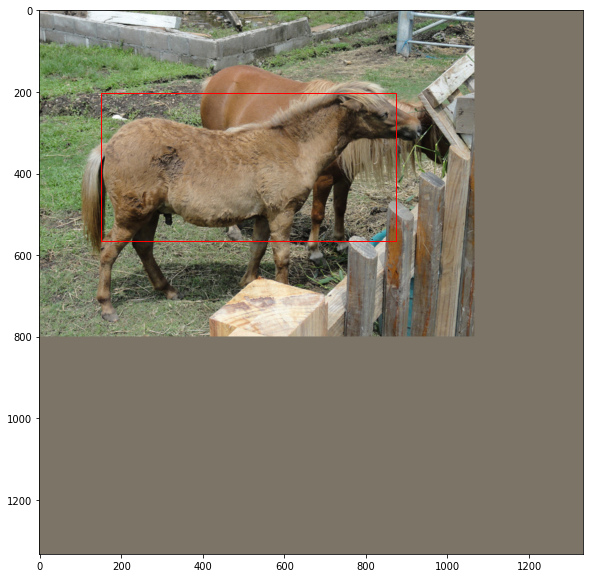

In [61]:
show_box(imgs[0], tf.concat(anchors[0], axis=0)[inds_list[0][0]])

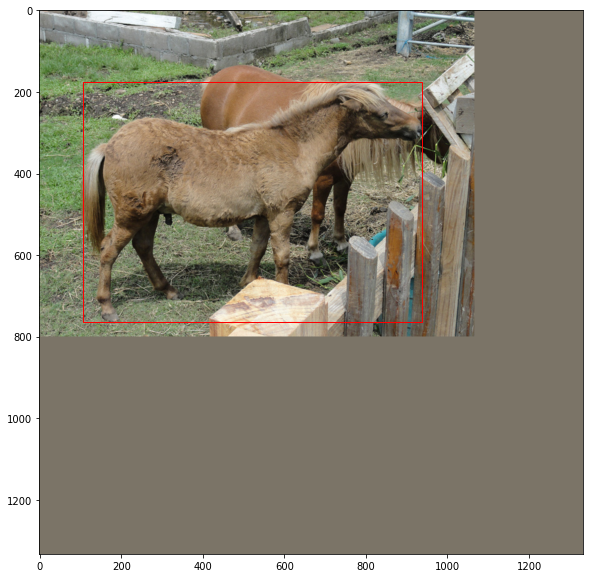

In [62]:
show_box(imgs[0], gt_bboxes[0][0])

In [63]:
flat_anchors = tf.concat(anchors[0], axis=0)
adjusted_anchors = bbox_coder.decode(flat_anchors, all_bbox_targets[0])

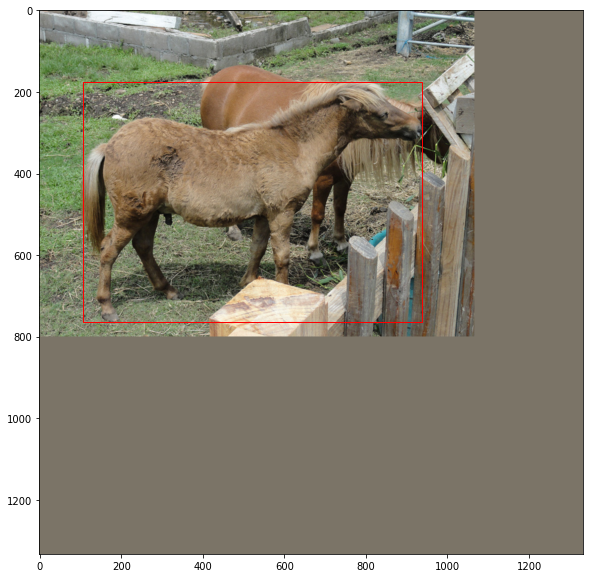

In [64]:
show_box(imgs[0], adjusted_anchors[inds_list[0][0]])

In [72]:
all_labels[0][inds_list[0][3]]

<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [45]:
get_targets(anchor_list,
            valid_flag_list,
            gt_bboxes,
            img_metas,
            gt_labels_list=None,
            label_channels=1
            unmap_outputs=True,
            return_sampling_results=False):
    num_imgs = len(img_metas)
    assert len(anchor_list) == len(valid_flag_list) == num_imgs
    num_level_anchors = [tf.size(anchors)[0] for anchors in anchor_list[0]]
    

def loss(cls_scores,
        bbox_preds,
        gt_bboxes,
        gt_labels,
        img_metas):
    featmap_sizes = [tf.shape(featmap)[1:3] for featmap in cls_scores]
    assert len(featmap_sizes) == rpn_head.anchor_generator.num_levels
    anchor_list, valid_flag_list = rpn_head.get_anchors(
            featmap_sizes, img_metas)
    

In [46]:
loss(rpn_probs, rpn_deltas, gt_bboxes, gt_labels, img_metas)

([[<tf.Tensor: shape=(334668, 4), dtype=float32, numpy=
   array([[ -22.627417,  -11.313708,   22.627417,   11.313708],
          [ -16.      ,  -16.      ,   16.      ,   16.      ],
          [ -11.313708,  -22.627417,   11.313708,   22.627417],
          ...,
          [1309.3726  , 1320.6863  , 1354.6274  , 1343.3137  ],
          [1316.      , 1316.      , 1348.      , 1348.      ],
          [1320.6863  , 1309.3726  , 1343.3137  , 1354.6274  ]],
         dtype=float32)>,
   <tf.Tensor: shape=(83667, 4), dtype=float32, numpy=
   array([[ -45.254833,  -22.627417,   45.254833,   22.627417],
          [ -32.      ,  -32.      ,   32.      ,   32.      ],
          [ -22.627417,  -45.254833,   22.627417,   45.254833],
          ...,
          [1282.7451  , 1305.3726  , 1373.2549  , 1350.6274  ],
          [1296.      , 1296.      , 1360.      , 1360.      ],
          [1305.3726  , 1282.7451  , 1350.6274  , 1373.2549  ]],
         dtype=float32)>,
   <tf.Tensor: shape=(21168, 4), dtyp